In [1]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras import backend as K
from keras.losses import categorical_crossentropy
from keras.models import Model

C:\Users\WuZihWun\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_image(img_path):
    img = Image.open(img_path).convert('RGB')
    return img

def trans(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def get_class(img):
    x=trans(img)
    features = model.predict(x)    
    return decode_predictions(features, top=1)[0] #取得第1個最可能的類別及機率
 
def draw_result(img,noise, adv_img):
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    orig_class, attack_class = get_class(img), get_class(adv_img)
    ax[0].imshow(img)
    ax[0].set_title('Original image: {}'.format(orig_class[0][1]))
    ax[1].imshow(noise)
    ax[1].set_title('Attacking noise')
    ax[2].imshow(adv_img)
    ax[2].set_title('Adversarial example: {}'.format(attack_class[0][1]))
    for i in range(3):
        ax[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    fig.savefig("result.png")

In [3]:
def get_gradientfunc(model,x,y):
    
    input_tensors = model.inputs + model.sample_weights + model.targets + [K.learning_phase()]
    
    gradients = K.gradients(model.total_loss, input_tensors[0]) # gradient tensors    

    get_gradients = K.function(inputs=input_tensors, outputs=gradients)
    
    inputs = [x, # X
              np.ones(len(x)), # sample weights
              y, # y
              0 # learning phase in TEST mode
    ]

    grads = get_gradients(inputs)
    
    return grads[0]

In [4]:
def non_targeted_attack(img):
    adversarial_img = img.copy()    
    
    for step in range(steps):
        out = model.predict(adversarial_img)
    
        gradients = get_gradientfunc(model, adversarial_img, out)
        np.asarray(gradients)
        
        normed_grad = step_alpha * np.sign(gradients)
        adv = np.clip(normed_grad, -eps, eps)
        adversarial_img = img + adv
        #adversarial_img = np.clip(adversarial_img, 0.0, 1.0)
        
    return image.array_to_img(adversarial_img[0]),image.array_to_img(np.sign(gradients)[0])


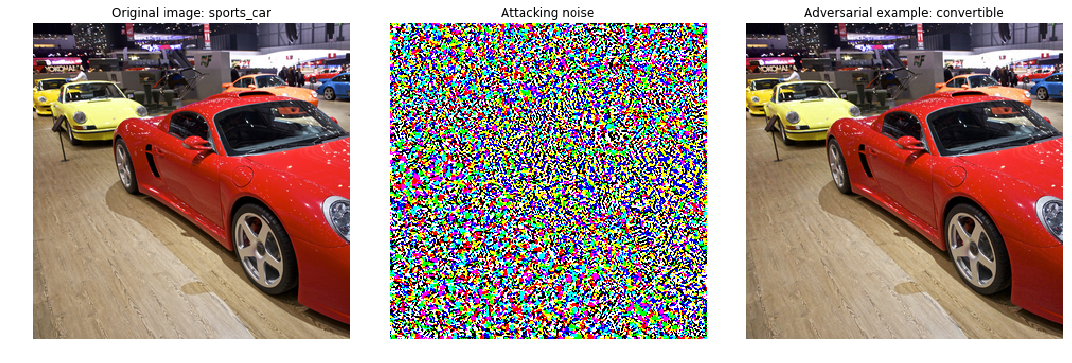

In [6]:
eps = 2 * 8 / 225 #The amount to wiggle towards the gradient of target class.
steps = 10
step_alpha = 0.01

# include_top=True，表示會載入完整的 VGG16 模型，包括加在最後3層的卷積層
# include_top=False，表示會載入 VGG16 的模型，不包括加在最後3層的卷積層，通常是取得 Features
model = InceptionV3(weights='imagenet', include_top=True)
model.compile(loss='categorical_crossentropy', optimizer='Adam')

img = load_image('input.png')
#img = load_image('cat.10087.jpg')
#img = load_image('dog.310.jpg')

trans_img = trans(img)
out = model.predict(trans_img)
adv_img,noise = non_targeted_attack(trans_img)

draw_result(img,noise, adv_img)